In [1]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
import scipy.ndimage
from scipy.ndimage import binary_closing
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
from utils import data_ut as dut
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from models.SAmodel import MyNetwork
from models.Unrolled import Unrolled
from ImageFusion_Dualbranch_Fusion.densefuse_net import DenseFuseNet
from ImageFusion_Dualbranch_Fusion.channel_fusion import channel_f as channel_fusion
import ut2 as ut

from RCAN import CombinedNetwork
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

In [2]:
!pwd

/home/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [3]:
!which python3

/bin/python3


In [2]:

# Path to your NIfTI file
# Original Slice
nii_file_target = './test_data/patient29b/T1_week152reg.nii'
nii_file_ref = './test_data/patient29b/T1_week165regT1_week152.nii'

# Good bew slice
#nii_file_target = './registered_data/patient28/T1_week25reg.nii'
#nii_file_ref = './registered_data/patient28/T1_week35regT1_week25.nii'

img_target = nib.load(nii_file_target)
img_ref = nib.load(nii_file_ref)
target = img_target.get_fdata()[...,20]
reference = img_ref.get_fdata()[...,20]
#target = img_target.get_fdata()[...,25]
#reference = img_ref.get_fdata()[...,25]

random_phase = torch.angle(T.random_map((1,256,160), 'cpu',kspace_radius_range=(0.001, 0.001))) 
target = target * (torch.exp(1j * random_phase)).numpy() 
target = target.squeeze(0)
target_torch = cplx.to_tensor(target).float() 
reference_torch = cplx.to_tensor(reference).float() 
reference_kspace_torch = T.fft2(reference_torch)
reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_kspace_torch = T.kspace_cut(reference_kspace_torch, 0.67,0.67)
#reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_torch = T.ifft2(reference_kspace_torch)
#reference = cplx.to_numpy(reference_torch)
kspace_torch = T.fft2(target_torch)
#kspace_torch = T.kspace_cut(kspace_torch, 0.67,0.67)
#target_torch = T.ifft2(kspace_torch)
target = cplx.to_numpy(target_torch)
kspace = cplx.to_numpy(kspace_torch)
# Print the shape of the data to verify
print(target_torch.shape)
mask2 = sp.mri.poisson((256,160),5, calib=(18,14), dtype=float, crop_corner=False, return_density=True, seed=0, max_attempts=6, tol=0.01)
mask2[128-10:128+9,80-8:80+7] = 1
mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)

mask_torch = T.kspace_crop(mask_torch,0.67)
kspace_torch = T.awgn_torch(kspace_torch,10,L=1)
kspace_torch = T.kspace_crop(kspace_torch,0.67)

print(kspace_torch.shape)
print(mask_torch.shape)
kspace_torch = kspace_torch*mask_torch

s = (256/1.5)*(160/1.5)
print((torch.sum(mask_torch))/s)


"""
data_R1 = np.load('../../T1w_T2w_R1_R2/data_T1w_IR_R1.npy')
data_full = np.fft.fftshift(np.fft.fftn((np.fft.fftshift(data_R1))))
slice_full = data_full[:,15:123,10]
target_height = 172
target_width = 108

# Calculate padding for height (top and bottom)
padding_top = (target_height - slice_full.shape[0]) // 2
padding_bottom = target_height - slice_full.shape[0] - padding_top

# Pad the array with zeros
slice_full = np.pad(slice_full, ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)

kspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(slice_full)), norm='ortho'))
target = np.fft.fftshift(np.fft.ifft2((np.fft.ifftshift(kspace)), norm='ortho'))

reference = np.pad(data_full[:,15:123,11], ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)
reference_kspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(reference)), norm='ortho'))

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
concat = np.concatenate((target,reference),axis =1 )
im1 = axs.imshow(np.abs(concat), cmap='gray') #np.log(np.abs(kspace))np.abs(slice_full)
plt.title('LF data')
plt.axis('off')
plt.show()
print(slice_full.shape)

"""

torch.Size([256, 160, 2])
torch.Size([256, 160, 2])
torch.Size([256, 160, 2])
tensor(0.6423)


"\ndata_R1 = np.load('../../T1w_T2w_R1_R2/data_T1w_IR_R1.npy')\ndata_full = np.fft.fftshift(np.fft.fftn((np.fft.fftshift(data_R1))))\nslice_full = data_full[:,15:123,10]\ntarget_height = 172\ntarget_width = 108\n\n# Calculate padding for height (top and bottom)\npadding_top = (target_height - slice_full.shape[0]) // 2\npadding_bottom = target_height - slice_full.shape[0] - padding_top\n\n# Pad the array with zeros\nslice_full = np.pad(slice_full, ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)\n\nkspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(slice_full)), norm='ortho'))\ntarget = np.fft.fftshift(np.fft.ifft2((np.fft.ifftshift(kspace)), norm='ortho'))\n\nreference = np.pad(data_full[:,15:123,11], ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)\nreference_kspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(reference)), norm='ortho'))\n\nfig, axs = plt.subplots(1, 1, figsize=(5, 5))\nconcat = np.concatenate((target,refe

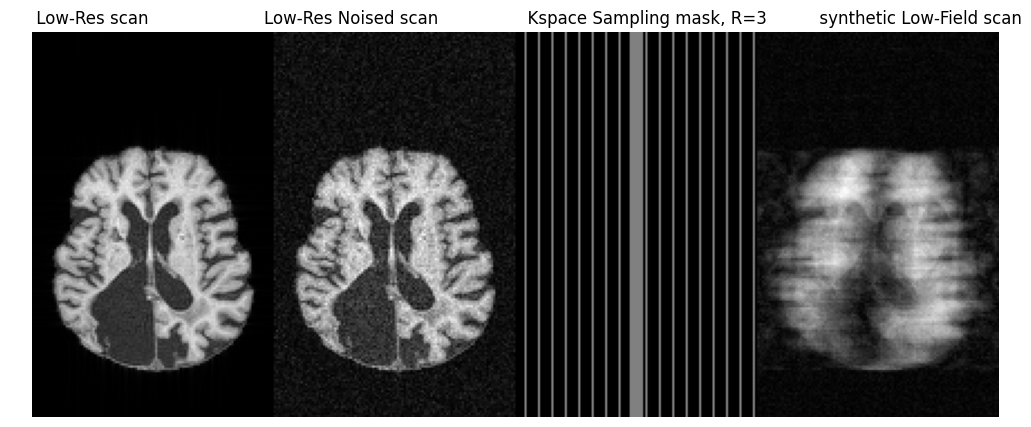

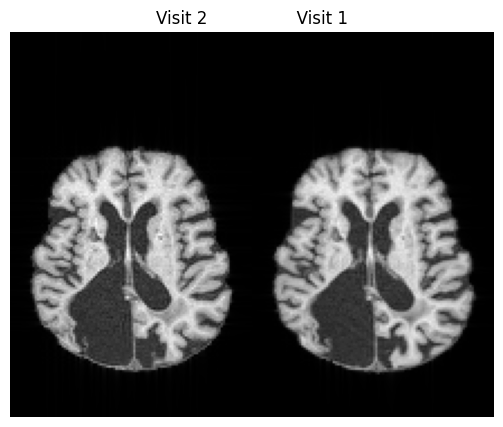

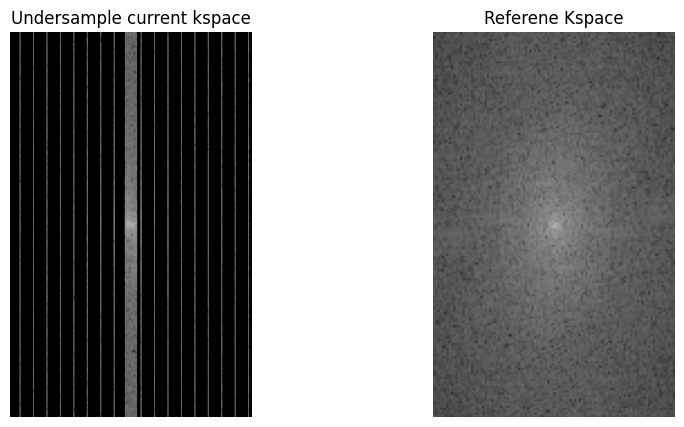

Mask torch size: (172, 108)
Acceleration factor R: 0.21296296296296297


In [3]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(256,24)),(256,160))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale

# Apply kspace crop on target
target_torch = cplx.to_tensor(target)
target_torch = T.ifft2( T.kspace_cut(T.fft2(target_torch),0.67,0.67))
# For plot
kspace_HR = np.abs(cplx.to_numpy(T.fft2(cplx.to_tensor(target))))
kspace_LR =cplx.to_numpy( T.kspace_crop(T.fft2( cplx.to_tensor(target)),0.67))
target_HR = target
target_LR = cplx.to_numpy(T.ifft2( T.kspace_crop(T.fft2( cplx.to_tensor(target)),0.67)))
target = cplx.to_numpy(target_torch)
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()
kspace_torch = T.awgn_torch(kspace_torch,10,L=1)
kspace_noised = kspace_torch.clone()
kspace_noised = T.kspace_cut(kspace_noised,0.67,0.67)
kspace_torch = T.kspace_cut(kspace_torch,0.67,0.67)
target_torch = cplx.to_tensor(target).float()

### Reference addition ###
im_lowres_ref = abs(sp.ifft(sp.resize(sp.resize(reference_kspace,(256,24)),(256,160))))
magnitude_vals_ref = im_lowres_ref.reshape(-1)
k_ref = int(round(0.05 * magnitude_vals_ref.shape[0]))
scale_ref = magnitude_vals_ref[magnitude_vals_ref.argsort()[::-1][k_ref]]
reference = reference / scale_ref
reference_torch = cplx.to_tensor(reference).float()
reference_torch_kspace = T.fft2(reference_torch)
reference_torch_kspace = T.kspace_cut(reference_torch_kspace,0.67,0.67)
reference_torch = T.ifft2(reference_torch_kspace)
"""
fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(cplx.to_numpy(mask_torch)), cmap='gray')
plt.show()
"""
#kspace_torch = kspace_torch*mask_torch

from fastmri.data import transforms, subsample
def get_mask_func(factor):
    center_fractions = 0.08 * 4/factor # RandomMaskFuncEquiSpacedMaskFunc
    mask_func = subsample.EquiSpacedMaskFunc(
    center_fractions=[center_fractions],
    accelerations=[factor], 
    )
    return mask_func
mask_func = get_mask_func(6)
kspace_torch = transforms.apply_mask(kspace_torch, mask_func)[0]

concat = np.concatenate((target,cplx.to_numpy(T.ifft2(kspace_noised)),np.abs(cplx.to_numpy(kspace_torch))!=0,cplx.to_numpy(T.ifft2(kspace_torch))),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('     Low-Res scan                      Low-Res Noised scan                 Kspace Sampling mask, R=3          synthetic Low-Field scan')
plt.axis('off')
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
concat2 = np.concatenate((cplx.to_numpy(target_torch),cplx.to_numpy(reference_torch)),axis=1)
im1 = axs.imshow(np.abs(concat2), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('Visit 2                 Visit 1')
plt.axis('off')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Log-transform the absolute value of the k-space and shift to avoid log(0)
log_kspace = np.log(np.abs(cplx.to_numpy(kspace_torch)) + 1e-10)
log_reference_kspace = np.log(np.abs(cplx.to_numpy(reference_torch_kspace)) + 1e-10)

# Use a colormap with higher contrast like 'hot' or 'viridis'
axs[0].imshow(log_kspace, cmap='gray', vmin=-10, vmax=10)  # Adjust vmin/vmax as needed
axs[0].set_title('Undersample current kspace')
axs[0].axis('off')

axs[1].imshow(log_reference_kspace, cmap='gray', vmin=-10, vmax=10)  # Adjust vmin/vmax as needed
axs[1].set_title('Referene Kspace')
axs[1].axis('off')

plt.show()
"""
concat = np.concatenate((target_HR,target_LR),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title(' High-Res scan (1x1[mm])        Low-Res scan (1.5x1.5[mm])   ')
plt.axis('off')
plt.show()

concat = np.concatenate((kspace_HR,kspace_LR),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.log(np.abs(concat)), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title(' High-Res kspace (1x1[mm])        Low-Res kspace (1.5x1.5[mm])   ')
plt.axis('off')
plt.show()
"""
mask_np = np.abs(cplx.to_numpy(kspace_torch))!=0
print(f'Mask torch size: {mask_np.shape}')
s = (172)*(108)
print(f'Acceleration factor R: {np.sum(mask_np)/s}')

Target shape: (172, 108)


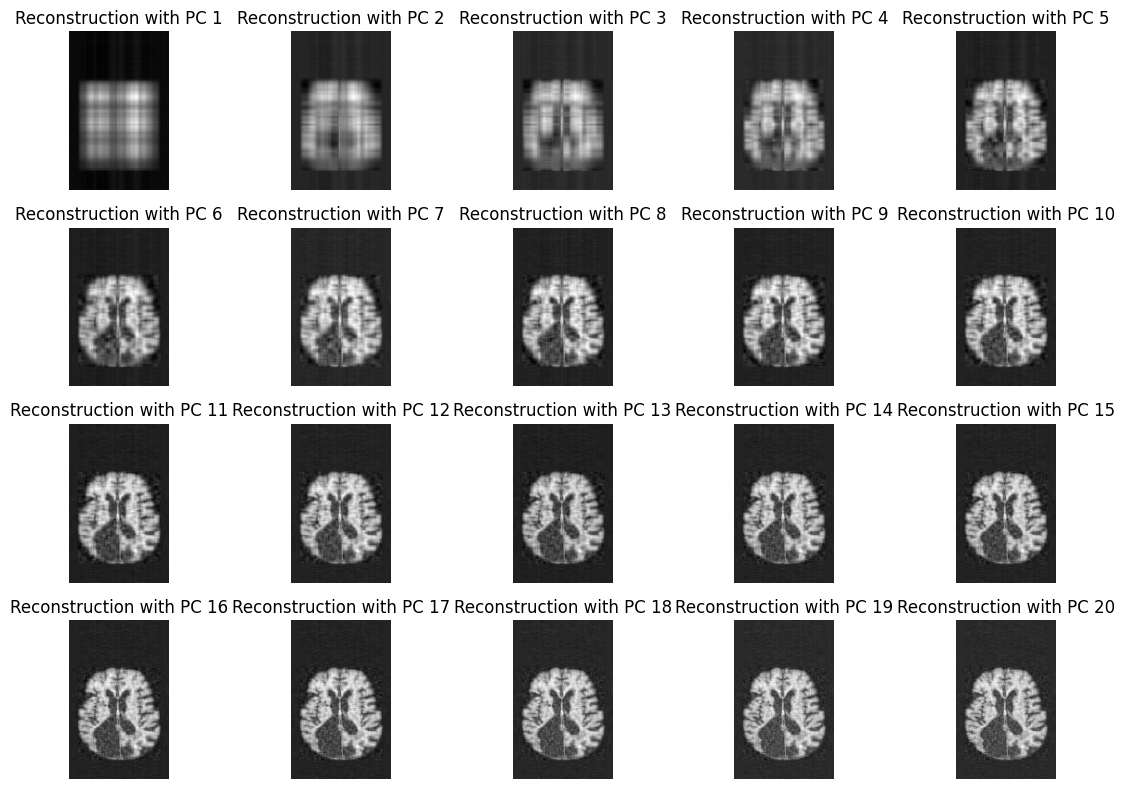

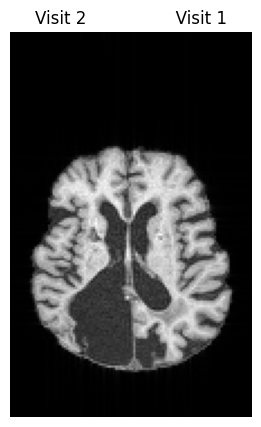

In [6]:
def compute_principal_components(image, num_components=None):
    """
    Compute the principal components of an image using PCA.

    Args:
        image: Tensor of shape (H, W) representing a grayscale image.
        num_components: Number of principal components to retain. If None, retain all.

    Returns:
        components: Principal components as a matrix.
        explained_variance: Variance explained by each component.
    """
    # Step 1: Flatten the image
    H, W = image.shape
    flattened_image = image.view(-1, W)  # Shape: (H, W)

    # Step 2: Center the data
    mean = flattened_image.mean(dim=0, keepdim=True)
    centered_data = flattened_image - mean

    # Step 3: Compute the covariance matrix
    covariance_matrix = torch.mm(centered_data.T, centered_data) / (H - 1)  # Shape: (W, W)

    # Step 4: Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)  # For symmetric matrices

    # Step 5: Sort eigenvalues and eigenvectors in descending order
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 6: Select the top components
    if num_components is not None:
        eigenvalues = eigenvalues[:num_components]
        eigenvectors = eigenvectors[:, :num_components]

    return eigenvectors, eigenvalues

def reconstruct_image(image, components, first_component, num_components):
    mean = image.mean(dim=0, keepdim=True)
    centered_data = image - mean
    projection = torch.mm(centered_data, components[:, first_component-1:num_components])
    reconstruction = torch.mm(projection, components[:, first_component-1:num_components].T) + mean
    return reconstruction

print(f'Target shape: {target.shape}')
image = np.abs(target)
image = np.abs(cplx.to_numpy(T.ifft2(kspace_noised)))
if not isinstance(image, torch.Tensor):
    image = torch.tensor(image, dtype=torch.float32)
# Compute principal components
components, explained_variance = compute_principal_components(image)

# Plot reconstructions using the first 6 principal components
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
axes = axes.flatten()

for i in range(20):  # Reconstruct using the first 6 PCs, one at a time
    reconstructed_image = reconstruct_image(image, components,first_component=1, num_components=i+1)
    axes[i].imshow(reconstructed_image.detach().numpy(), cmap='gray')
    axes[i].set_title(f"Reconstruction with PC {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
im1 = axs.imshow(np.abs(target), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('Visit 2                 Visit 1')
plt.axis('off')
plt.show()

In [7]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [8]:
#Hyper parameters
params = Namespace()
#params.data_path = "./registered_data/patient23b/"
params.data_path = "./registered_data/"
params.batch_size = 2
params.num_grad_steps = 1 #4
params.num_cg_steps = 8 #8
params.share_weights = True
params.modl_lamda = 0.05
params.lr = 0.00001
#params.lr = 0.0001
params.weight_decay = 0
params.lr_step_size = 7
params.lr_gamma = 0.1
params.epoch = 61
params.reference_mode = 1
params.reference_lambda = 0.1

In [9]:

#3checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolledPlug/model_5.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT/model_15.pt"  # 35 - is good one
#checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT_finetune/model_15.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_tests/model_10.pt" # SSIM + style layer 3 only
#checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_tests2/model_15.pt" #15 is for x3 10dB
checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_tests3/model_10.pt"
checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_tests3_grant/model_10.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT_finetuneall_LR/model_15.pt"
checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_complex/model_10.pt"

checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_tests3/model_10.pt"
#checkpoint_file = "./L2_checkpoints_ViT_only/model_60.pt"
#checkpoint_file = "./L2_checkpoints_myTrain/model_15.pt"

## Upgrades:
checkpoint_file = "./ViT_Fuser_checkpints_upgrade/model_15.pt"
checkpoint_file = "./checkpoints_ViT_fuser_aug/model_40.pt"

## New loss:
#checkpoint_file = "./checkpoints_new_loss/model_10.pt"


checkpoint = torch.load(checkpoint_file,map_location=device)
# Init model
from vision_transformer import VisionTransformer
from recon_net import ReconNet

#from UnrolledViT import UnrolledViT
from UnrolledViT import UnrolledViT
model = UnrolledViT(params).to(device)

# load checkpoint
#cp = torch.load('./lsdir-2x+hq50k_vit_epoch_60.pt', map_location=device)
#checkpoint_file = "./L2_checkpoints_poisson_x2_FusionNetViT/model_30.pt"

### UN-comment!!!
model.load_state_dict(checkpoint['model'])


shared weights


<All keys matched successfully>

torch.Size([1, 1, 172, 108])
torch.Size([172, 108, 2])
torch.Size([172, 108, 2])
torch.Size([172, 108, 1])
torch.Size([172, 108, 2])
(172, 108)


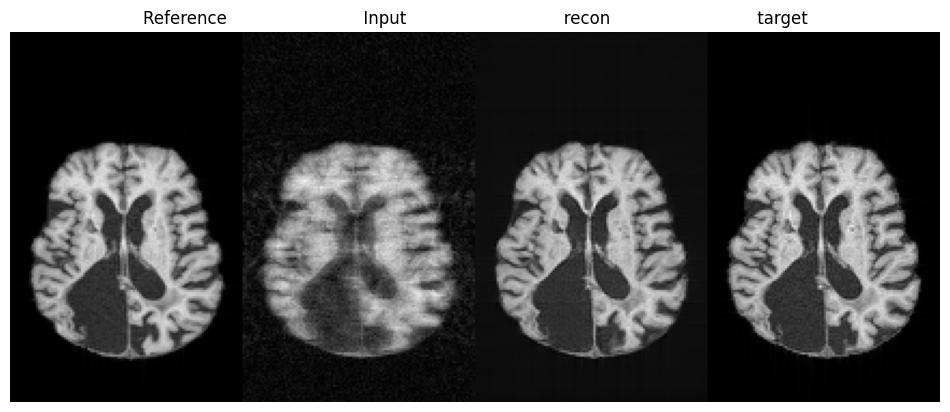

In [10]:


img = cplx.to_tensor(np.abs(cplx.to_numpy(T.ifft2(kspace_torch)))).permute(2,0,1).unsqueeze(0).to(device)
img_chan = img[:,0,:,:].unsqueeze(0)
ref = cplx.to_tensor(np.abs(cplx.to_numpy(reference_torch))).permute(2,0,1).unsqueeze(0).to(device)
ref_chan = ref[:,0,:,:].unsqueeze(0)
ref_np = ref_chan.cpu().numpy()[0,0,:,:]
print(img_chan.shape)
img_padded_np = img_chan.cpu().numpy()[0,0,:,:]
"""
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
im1 = axs.imshow(np.abs(np.concatenate((img_padded_np,target),axis=1)), cmap='gray') 
plt.title('LF data')
plt.axis('off')
plt.show()
print(slice_full.shape)

output = model(img_chan.float())

#vgg_features = model.encoder(input)
print(output.shape)
#print(vgg_features.shape)
ref_np = ref_chan.cpu().numpy()[0,0,:,:]
img_padded_np = img_chan.cpu().numpy()[0,0,:,:]
output_np = output.cpu().detach().numpy()[0,0,:,:]

# Norm
in_pad, wpad, hpad = model.pad(img_chan)
ref_pad, wpad, hpad = model.pad(ref_chan)
input_norm,mean,std = model.norm(in_pad.float())
ref_norm,mean_ref,std_ref = model.norm(ref_pad.float())
# Feature extract
features = model.net.forward_features(input_norm)
features_ref = model.net.forward_features(ref_norm)
features_comb = (7*features + 3*features_ref)/10

# Recon Head
head_out = model.net.head(features_comb) 
head_out_img = model.net.seq2img(head_out, (260, 160))

# un-norm
merged = model.unnorm(head_out_img, mean, std) 

# un-pad 
im_out = model.unpad(merged,wpad,hpad)
"""
print(kspace_torch.shape)
print(reference_torch.shape)
im_out = model(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(im_out.shape)
im_out_pad = torch.cat((im_out,torch.zeros_like(im_out)),dim=2)
print(im_out_pad.shape)
im_out = T.ifft2(T.fft2(im_out_pad))
target_torch = T.ifft2(T.fft2(cplx.to_tensor(target)))
target = cplx.to_numpy(target_torch.cpu().detach())
#merged_np = im_out.cpu().detach().numpy()[0,:,:,:]
#im_out = np.sqrt(merged_np[:,:,0]**2 + merged_np[:,:,1]**2)
im_out = np.abs(cplx.to_numpy(im_out.cpu().detach()))
#im_out = 1-(np.abs(im_out)-np.abs(target))
print(im_out.shape)
"""
print(f'features_comb shape: {features_comb.shape}')
print(f'head_out shape: {head_out.shape}')
print(f'merged shape: {merged.shape}')
print(f'output_np shape: {output_np.shape}')
print(f'ref_np shape: {ref_np.shape}')
print(f'img_padded_np shape: {img_padded_np.shape}')
print(f'target shape: {target.shape}')
print(f'features shape: {features.shape}')
"""
# Concatenate images horizontally
concatenated_image = np.concatenate((ref_np,img_padded_np, im_out,np.abs(target)),axis=1)
# Plot the concatenated image
plt.figure(figsize=(12, 6))
plt.imshow(concatenated_image, cmap='gray')
plt.title('Reference                          Input                              recon                            target')
plt.axis('off')
plt.show()


In [11]:
kspace_torch.shape
reference_torch.shape

torch.Size([172, 108, 2])

(172, 108)


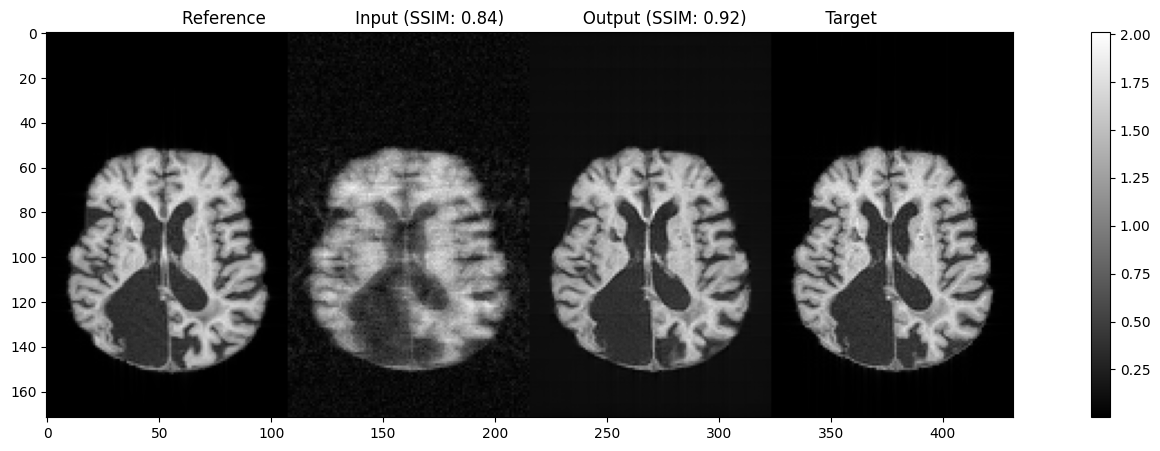

In [12]:
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import binary_fill_holes
def compute_psnr(img1, img2, maxval):
    """Computes PSNR in dB"""
    mse = np.mean((img1 - img2) ** 2)

    return (10 * np.log10(maxval / mse)).item()
cplx_image_target = target
cplx_image_in = img_padded_np
cplx_image_out = im_out

cplx_image_reference = ref_np
maxval = np.max(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out),axis=0)))
minval = np.min(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out),axis=0)))

target_numpy_norm = np.abs(cplx_image_target)/maxval
input_numpy_norm = np.abs(cplx_image_in)/maxval
out_numpy_norm = np.abs(cplx_image_out)/maxval

# Area calib
# Find comparison area:
area = target_numpy_norm > 0.30
kernel = np.ones((10, 10)) / 25.0
#area = np.convolve(area, kernel, mode='constant', cval=0.0)
area = scipy.ndimage.convolve(area.astype(float), kernel, mode='constant', cval=0.0)
area[area>0.009] = 1
structuring_element = np.ones((4,4))
area = binary_closing(area, structure=structuring_element)
area = binary_fill_holes(area)

target_numpy_norm = target_numpy_norm * area
input_numpy_norm = input_numpy_norm * area
out_numpy_norm = out_numpy_norm * area


psnr_in = compute_psnr(target_numpy_norm, input_numpy_norm,1)
psnr_out = compute_psnr(target_numpy_norm,out_numpy_norm,1)
data_range = maxval - minval
ssim_in, _ = ssim(target_numpy_norm, input_numpy_norm, data_range=data_range, full=True)
ssim_out, _ = ssim(target_numpy_norm, out_numpy_norm, data_range=data_range, full=True)
"""
# Create a figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs[0].imshow(np.flipud(np.abs(cplx_image_in)), cmap='gray')
axs[0].set_title('Input')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.flipud(np.abs(cplx_image_out)), cmap='gray')
axs[1].set_title('Output')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.flipud(np.abs(cplx_image_target)), cmap='gray')
axs[2].set_title('Target')
fig.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.show()
"""
print(cplx_image_out.shape)
plt_concat = np.concatenate((np.abs(cplx_image_reference),np.abs(cplx_image_in),np.abs(cplx_image_out),np.abs(cplx_image_target)),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
im = axs.imshow(plt_concat, cmap='gray')
axs.set_title(f'Reference                 Input (SSIM: {ssim_in:.2f})               Output (SSIM: {ssim_out:.2f})               Target')
#axs.set_title(f'Reference                         Input                         Output                                 Target')
fig.colorbar(im, ax=axs)
plt.show()




(172, 108)
(172, 108)
(172, 108)


/tmp/ipykernel_240685/566286739.py:11: RuntimeWarning: divide by zero encountered in log
  im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')


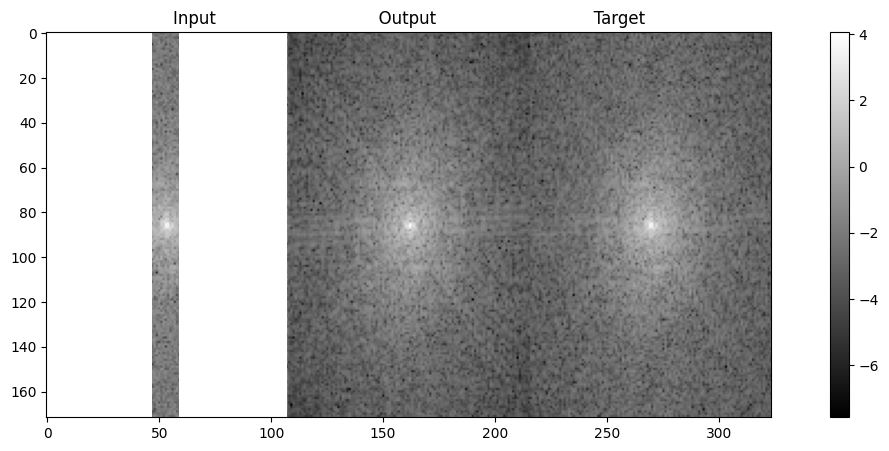

/tmp/ipykernel_240685/566286739.py:16: RuntimeWarning: divide by zero encountered in log
  pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))
/home/tal/.local/lib/python3.10/site-packages/matplotlib/image.py:453: RuntimeWarning: invalid value encountered in double_scalars
  vmid = np.float64(self.norm.vmin) + dv / 2


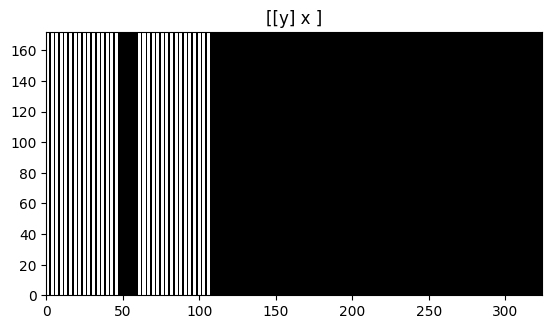

In [13]:

print(cplx_image_target.shape)
print(cplx_image_in.shape)
print(cplx_image_out.shape)
# Create a figure and axes
kspace_in = cplx.to_numpy(kspace_torch)
kspace_out = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_out))))
kspace_target = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_target))))

plt_concat = np.concatenate((kspace_in,kspace_out,kspace_target),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns
im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')
axs.set_title('Input                               Output                              Target')
fig.colorbar(im, ax=axs)
plt.show()

pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torchvision

model_ft = models.vgg16(weights='DEFAULT').requires_grad_(False)

In [15]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
#model_ft.fc = nn.Identity()
model.classifier = nn.Identity()
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

: 